<a href="https://colab.research.google.com/github/SnehaVenkatesh19/B2B-Lead-Conversion-Prediction/blob/main/B2B_Lead_Scoring_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

file_path = '/content/drive/MyDrive/Datasets/lead_scoring.csv'
df = pd.read_csv(file_path)

df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


#Dropping columns with high missing values
drop_cols = [
    'Lead Number', 'Tags', 'Lead Quality', 'Lead Profile',
    'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
    'Asymmetrique Activity Score', 'Asymmetrique Profile Score'
]
df.drop(columns=drop_cols, inplace=True)

#Converting 'Yes'/'No' columns to binary 1/0
binary_cols = [
    'Do Not Email', 'Do Not Call', 'Search', 'Magazine',
    'Newspaper Article', 'X Education Forums', 'Newspaper',
    'Digital Advertisement', 'Through Recommendations',
    'Receive More Updates About Our Courses',
    'Update me on Supply Chain Content',
    'Get updates on DM Content',
    'I agree to pay the amount through cheque',
    'A free copy of Mastering The Interview'
]

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

#Filling remaining nulls and categorical nulls with "Unknown"
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

#Filling numerical nulls with 0
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(0)

#Dropping ID column
df.drop(columns=['Prospect ID'], inplace=True)



In [4]:
#splitting data into X and y
X = df.drop(columns=['Converted'])
y = df['Converted']

#get categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

#Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

#Splitting into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Train shape: (7392, 27)
Test shape: (1848, 27)
Numerical columns: ['Do Not Email', 'Do Not Call', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']
Categorical columns: ['Lead Origin', 'Lead Source', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'City', 'Last Notable Activity']


Logistic Regression Model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

#Create pipeline with preprocessor + logistic regression
logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

#train
logreg_pipe.fit(X_train, y_train)

#prediction
y_pred_logreg = logreg_pipe.predict(X_test)
y_proba_logreg = logreg_pipe.predict_proba(X_test)[:, 1]

#Evaluate
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_logreg):.4f}")


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1136
           1       0.76      0.71      0.74       712

    accuracy                           0.80      1848
   macro avg       0.79      0.79      0.79      1848
weighted avg       0.80      0.80      0.80      1848

ROC-AUC Score: 0.8778


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

#Training
rf_pipe.fit(X_train, y_train)

#Prediction
y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1136
           1       0.77      0.72      0.75       712

    accuracy                           0.81      1848
   macro avg       0.80      0.79      0.80      1848
weighted avg       0.81      0.81      0.81      1848

ROC-AUC Score: 0.8779


Feature importance on random forest

/tmp/ipython-input-12-2632693054.py:32: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


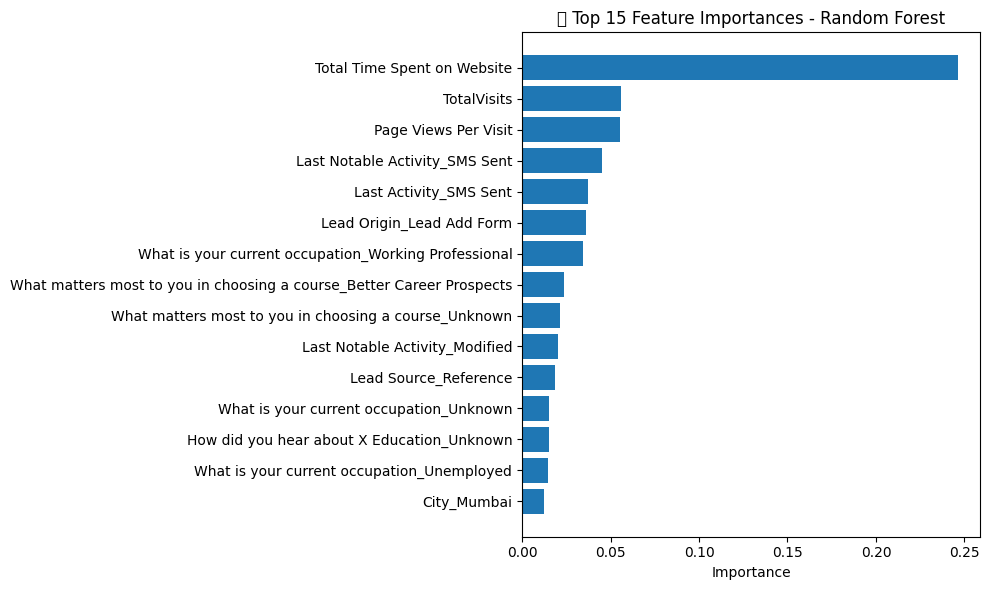

In [12]:
import matplotlib.pyplot as plt

# Get numeric and categorical transformers from the ColumnTransformer
preprocessor = rf_pipe.named_steps['preprocessor']

# Get the feature names after encoding
# Numeric features - no change
numeric_features_out = preprocessor.transformers_[0][2]  # Just names

# Categorical features - OneHot encoded
cat_transformer = preprocessor.transformers_[1][1]  # Pipeline for categorical
ohe = cat_transformer.named_steps['onehot']
categorical_features_out = ohe.get_feature_names_out(input_features=preprocessor.transformers_[1][2])

# Combine
all_feature_names = np.concatenate([numeric_features_out, categorical_features_out])

# Match with feature importances
importances = rf_pipe.named_steps['classifier'].feature_importances_

# Build DataFrame
importances_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'][::-1], importances_df['importance'][::-1])
plt.xlabel("Importance")
plt.title("🔍 Top 15 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


XGBoost

In [7]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Training
pipe_xgb.fit(X_train, y_train)

# Prediction
y_pred_xgb = pipe_xgb.predict(X_test)
y_proba_xgb = pipe_xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_xgb):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1136
           1       0.77      0.75      0.76       712

    accuracy                           0.82      1848
   macro avg       0.81      0.81      0.81      1848
weighted avg       0.82      0.82      0.82      1848


ROC-AUC Score: 0.8895


In [8]:
!pip install shap --quiet
import shap

In [13]:
# Load SHAP's explainer (specific to tree models like XGBoost)
# Get the transformed test features
X_test_processed = pipe_xgb.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(pipe_xgb.named_steps['classifier'], X_test_processed, feature_names=all_feature_names)


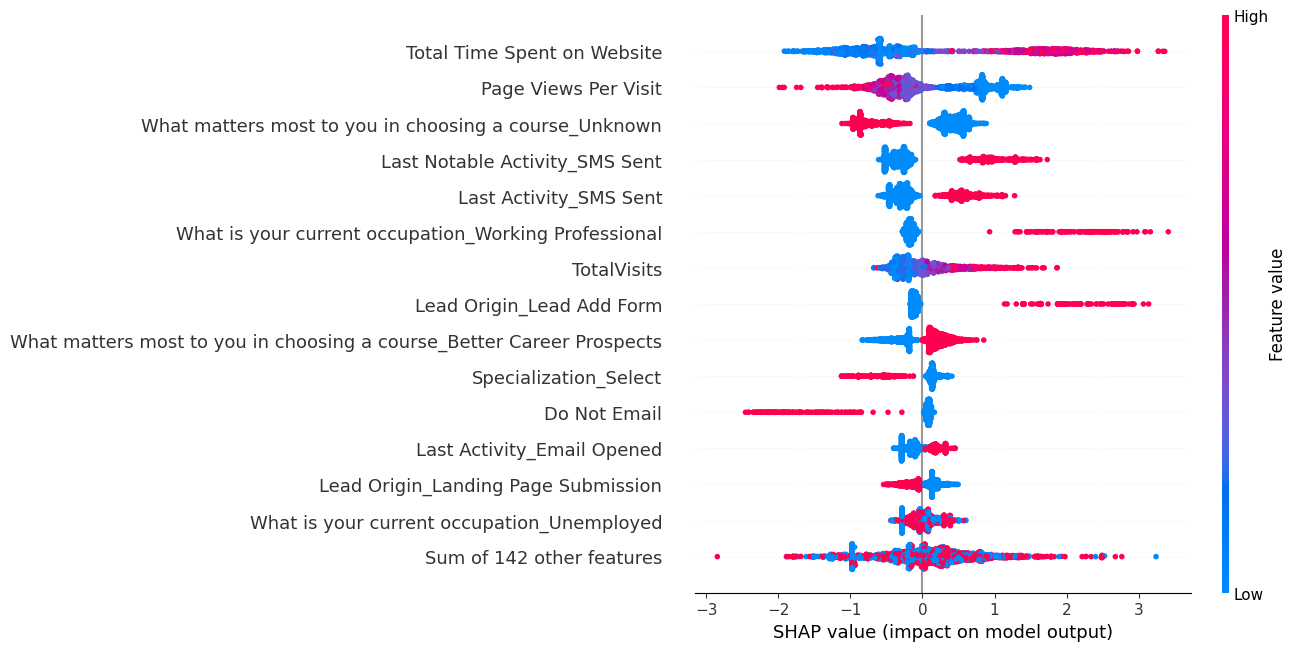

In [14]:
# Compute SHAP values
shap_values = explainer(X_test_processed)

# Global beeswarm plot
shap.plots.beeswarm(shap_values, max_display=15)


In [15]:
import joblib

# Saving the full pipeline (preprocessor + model)
joblib.dump(pipe_xgb, 'model.pkl')


['model.pkl']

In [16]:
from google.colab import files
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import sklearn
print(sklearn.__version__)


1.6.1


In [18]:
print(X_train.columns.tolist())


['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'City', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


In [22]:
import pandas as pd

# Sample test lead — replace values with realistic examples from your dataset
# 1. Create a sample lead dictionary with all required columns
# 1. Create a sample lead dictionary with all required columns
sample_data = {
    'Lead Origin': ['Landing Page Submission'],
    'Lead Source': ['Google'],
    'Do Not Email': ['No'],
    'Do Not Call': ['No'],
    'TotalVisits': [5],
    'Total Time Spent on Website': [500],
    'Page Views Per Visit': [3.5],
    'Last Activity': ['Email Opened'],
    'Country': ['India'],
    'Specialization': ['Finance Management'],
    'How did you hear about X Education': ['Online Search'],
    'What is your current occupation': ['Unemployed'],
    'What matters most to you in choosing a course': ['Better Career Prospects'],
    'Search': ['Yes'],
    'Magazine': ['No'],
    'Newspaper Article': ['No'],
    'X Education Forums': ['No'],
    'Newspaper': ['No'],
    'Digital Advertisement': ['No'],
    'Through Recommendations': ['No'],
    'Receive More Updates About Our Courses': ['Yes'],
    'Update me on Supply Chain Content': ['No'],
    'Get updates on DM Content': ['No'],
    'City': ['Mumbai'],
    'I agree to pay the amount through cheque': ['No'],
    'A free copy of Mastering The Interview': ['Yes'],
    'Last Notable Activity': ['SMS Sent']
}

# 2. Create DataFrame
sample_lead = pd.DataFrame(sample_data)

# 3. Add missing columns from X_train
for col in X_train.columns:
    if col not in sample_lead.columns:
        sample_lead[col] = np.nan

# 4. Ensure the column order and datatypes match
sample_lead = sample_lead[X_train.columns]

# Cast columns to correct types
for col in categorical_cols:
    if col in sample_lead.columns:
        sample_lead[col] = sample_lead[col].astype('object')

for col in numerical_cols:
    if col in sample_lead.columns:
        sample_lead[col] = pd.to_numeric(sample_lead[col], errors='coerce')

# 5. Predict
pred = pipe_xgb.predict(sample_lead)[0]
proba = pipe_xgb.predict_proba(sample_lead)[0][1]

# 6. Output
print(f" Prediction: {'Converted' if pred == 1 else 'Not Converted'}")
print(f" Probability of Conversion: {proba:.2f}")



 Prediction: Not Converted
 Probability of Conversion: 0.48
